In [1]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt
from shapely import wkt
%matplotlib inline
import os
import numpy as np
import geoplot
from mpl_toolkits.mplot3d import Axes3D
import itertools
import pygeohash as pgh
from shapely.geometry import Point, Polygon
import itertools
import scipy.stats as stats

In [ ]:
'''
here we load our final dataset that we've been working on  to get this final structure. the data was originally in the form
of just points taken from the opendc database (https://opendata.dc.gov/datasets/crime-incidents-in-2019). in the website
you have a collection of csv files with reported crimes and where they happened. we had merged all the data for years 2010- 2017.
and changed the points into these crime counts per bucket. (here the bucket we use is the "year, week, geohash")
we bucketed them in order to have a nice consistent structure to feed into a machine learning algorithm. having
all the data points as simple a point in 2d space with varying days makes it harder to predict crimes as crimes happen
at different times/places etc. ml programs need to have consistent data where every row is more or less in the same
geospatial time frame in order to make good predictions. as you can see we have made a lot of transformations. weather data
was taken from https://www.ncdc.noaa.gov/ and also grouped and averaged in order to fit the csv structure we made
having similar time frames, although for weather it's spatially invariant, but has temporal changes. this is due to the fact
that we only have access to so many weather stations and weather doesnt drastacally differ between geohashes.
wattage and distance transformations was also taken from open dc, after geospatial transformation distances of crimes to respective
points were calculated/ aggregated and averaged. this shows us whether or not certain enviromental features
can contribute to the prediction of crime in particular areas. data transformations was tedious and took 
many different notebooks that are a bit disorganized. so upon request i may decide to clean them and post it in order
for readers to have a much clearer understanding of the geospatial transformations. otherwise we load the data set
and run the model 
'''

In [2]:
crime_final = pd.read_csv('abs (4).csv')

In [3]:
crime_final = crime_final[crime_final['year']>2009]

In [4]:
crime_final.head()

,year,week,geohash,crime_count_w-0,population,holidays,AWND,PRCP,TMAX,TMIN,...,crime_count_w-3,crime_count_w-4,crime_count_w-5,crime_count,crime_count_n-1,crime_count_n-2,crime_count_n-3,crime_count_n-4,parking_meter_distances,distance_from_traffic_camera
0,2010,6,hf79gk,0.0,1821.117647,0.0,10.031429,0.134286,34.285714,19.571429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.125000,0.045225,0.009987
1,2010,6,hf79gm,0.0,1821.117647,0.0,10.031429,0.134286,34.285714,19.571429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.111111,0.045815,0.004561
2,2010,6,hf79gq,0.0,1821.117647,0.0,10.031429,0.134286,34.285714,19.571429,...,0.0,1.0,1.0,0.0,0.0,0.0,0.000,0.111111,0.047044,0.001489
3,2010,6,hf79gr,0.0,1662.235294,0.0,10.031429,0.134286,34.285714,19.571429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.200000,0.048863,0.006631
4,2010,6,hf79gs,0.0,1821.117647,0.0,10.031429,0.134286,34.285714,19.571429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.090909,0.034255,0.003835


In [5]:
crime_final.shape

(116440, 31)

In [ ]:
'''
this was our original structure spreadout into points and clusters. you can see that our new structure is not only clearer but 
also more suited for machine learning.
'''

In [6]:
test = pd.read_csv('crimedf2.csv')

In [7]:
test.head()

,Unnamed: 0.1.1,crime_loc,Cluster,offense,start_date,cluster_shape,cluster_area,population_of_clusterbyyear,geohash_population_by_year,start_date_year,...,start_date_weekday,start_date_time,crime_latitude,crime_longitude,geohash_name,geohash_shape,median_income_year_pointintract,tract_shape,no_of_geohashes_in_cluster,groceries in geohash
0,1561,POINT (-76.98007448283551 38.9171835065702),Cluster 23,THEFT F/AUTO,2009-05-09T22:00:00Z,POLYGON ((-76.96971543439622 38.91740416395668...,3.516219e+06,13987.0,913.862245,2009.0,...,5.0,22:00:00,-76.980074,38.917184,hf7djd,"POLYGON ((-76.9757080078125 38.924560546875, -...",NaN,POLYGON ((-76.99280728128994 38.90426578859756...,14,0
1,1641,POINT (-76.98192360736989 38.900734571025),Cluster 23,THEFT F/AUTO,2009-05-22T23:30:00Z,POLYGON ((-76.96971543439622 38.91740416395668...,3.516219e+06,13987.0,1490.761375,2009.0,...,4.0,23:00:00,-76.981924,38.900735,hf7dj1,"POLYGON ((-76.981201171875 38.902587890625, -7...",NaN,POLYGON ((-76.97139027532297 38.90345678947101...,14,0
2,1668,POINT (-76.9730984838471 38.9165515256135),Cluster 23,THEFT F/AUTO,2009-06-14T00:00:00Z,POLYGON ((-76.96971543439622 38.91740416395668...,3.516219e+06,13987.0,720.600648,2009.0,...,6.0,00:00:00,-76.973098,38.916552,hf7dje,"POLYGON ((-76.97021484375 38.924560546875, -76...",NaN,POLYGON ((-76.95704927083872 38.90791379020909...,14,0
3,1674,POINT (-76.98393790568301 38.91475185171669),Cluster 23,THEFT F/AUTO,2009-06-21T13:00:00Z,POLYGON ((-76.96971543439622 38.91740416395668...,3.516219e+06,13987.0,915.357143,2009.0,...,6.0,13:00:00,-76.983938,38.914752,hf7dj9,"POLYGON ((-76.981201171875 38.924560546875, -7...",NaN,POLYGON ((-76.99280728128994 38.90426578859756...,14,1
4,1675,POINT (-76.9772864123957 38.9095709532037),Cluster 23,THEFT F/AUTO,2009-06-12T14:00:00Z,POLYGON ((-76.96971543439622 38.91740416395668...,3.516219e+06,13987.0,999.071429,2009.0,...,4.0,14:00:00,-76.977286,38.909571,hf7dj6,"POLYGON ((-76.9757080078125 38.91357421875, -7...",NaN,POLYGON ((-76.95704927083872 38.90791379020909...,14,0


In [8]:
crime_final['target_crime_classificiation'] = crime_final['crime_count'].apply(lambda x: 0 if x == 0 else 1 )

In [9]:
# crime_final['crime_count_overpop'] = crime_final['crime_count'] /crime_final['population']

In [10]:
# crime_final['wattage / pop'] = crime_final['light_wattage'] / crime_final['population']

In [11]:
x_cols = ['crime_count_w-0','crime_count_w-1','crime_count_w-2','crime_count_w-3','crime_count_w-4','population','distance_to_station','AWND','PRCP','TMIN','TMAX',
          'median income','light_wattage','churches','crime_count_n-1','crime_count_n-2','crime_count_n-3'
          ,'crime_count_n-4','distances to metro ','parking_meter_distances','distance_from_traffic_camera']

In [12]:
X = crime_final[x_cols]

In [13]:
y = crime_final['target_crime_classificiation']

In [14]:
X.head()

,crime_count_w-0,crime_count_w-1,crime_count_w-2,crime_count_w-3,crime_count_w-4,population,distance_to_station,AWND,PRCP,TMIN,...,median income,light_wattage,churches,crime_count_n-1,crime_count_n-2,crime_count_n-3,crime_count_n-4,distances to metro,parking_meter_distances,distance_from_traffic_camera
0,0.0,0.0,0.0,0.0,0.0,1821.117647,0.058134,10.031429,0.134286,19.571429,...,31071.718297,26155.0,0.0,0.0,0.0,0.000,0.125000,0.091540,0.045225,0.009987
1,0.0,0.0,0.0,0.0,0.0,1821.117647,0.056604,10.031429,0.134286,19.571429,...,30798.181250,30325.0,0.0,0.0,0.0,0.000,0.111111,0.091842,0.045815,0.004561
2,0.0,0.0,0.0,0.0,1.0,1821.117647,0.054787,10.031429,0.134286,19.571429,...,26479.614015,25910.0,2.0,0.0,0.0,0.000,0.111111,0.092473,0.047044,0.001489
3,0.0,0.0,0.0,0.0,0.0,1662.235294,0.053191,10.031429,0.134286,19.571429,...,32151.000000,5000.0,0.0,0.0,0.0,0.000,0.200000,0.093430,0.048863,0.006631
4,0.0,0.0,0.0,0.0,0.0,1821.117647,0.048880,10.031429,0.134286,19.571429,...,34356.800000,55970.0,2.0,0.0,0.0,0.125,0.090909,0.081273,0.034255,0.003835


In [ ]:
'''
we check the correlation and sure enough most of then features we had engineered have correlations and those that do not
had at least some distributions that seemed to be useful 
'''

In [15]:
X.corr(method='spearman')['crime_count_w-0'].sort_values()

distances to metro             -0.343710
distance_to_station            -0.316966
parking_meter_distances        -0.290468
distance_from_traffic_camera   -0.237409
AWND                           -0.024784
median income                  -0.003235
PRCP                           -0.001003
TMAX                            0.027316
TMIN                            0.029113
crime_count_n-4                 0.103998
crime_count_n-3                 0.234641
population                      0.238386
crime_count_n-2                 0.325477
crime_count_w-4                 0.384739
crime_count_w-3                 0.385692
crime_count_w-2                 0.388463
churches                        0.391709
crime_count_n-1                 0.397554
crime_count_w-1                 0.397756
light_wattage                   0.450892
crime_count_w-0                 1.000000
Name: crime_count_w-0, dtype: float64

In [16]:
# plt.scatter(X['median income'], X['crime_count_w-1'])

In [17]:
X_scaled = StandardScaler().fit_transform(X)

In [18]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_scaled,y)

In [19]:
# Xtrain.head()

In [20]:
# classifier = RandomForestClassifier(n_estimators=100)
# scores_roc_auc = cross_val_score(classifier, Xtrain,ytrain, cv = kfold, scoring ='roc_auc')

In [21]:
# scores.mean()

In [22]:
nb = GaussianNB()
nb_scores_precision = cross_val_score(nb,Xtrain,ytrain, cv=5, scoring ='precision')
nb_scores_recall = cross_val_score(nb,Xtrain,ytrain, cv=5, scoring ='recall')

In [23]:
print(nb_scores_precision.mean(), 'precision')
print(nb_scores_recall.mean(), 'recall')

0.6662087387000193 precision
0.48387851888841615 recall


In [24]:
(len(X.columns)**0.5)*1/2

2.29128784747792

In [ ]:
'''
here we run random search to check the best parameters for our algorithm
'''

In [25]:
param_dist = {
    'criterion':['gini','entropy'],
    'max_depth': [3,6,9,12,None],
    'min_samples_split': [2,10,20,30,40,50],
    'max_features': ['auto','log2'],
    'bootstrap': [True, False],
}

rand_search = RandomizedSearchCV(RandomForestClassifier(n_estimators=100), param_distributions=param_dist,n_iter=100, scoring= 'f1_weighted', cv=3, iid=True,n_jobs=-1)

In [26]:
rand_search.fit(Xtrain,ytrain)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=100,
                                                    n_jobs=None,
 

In [27]:
x = pd.DataFrame(rand_search.cv_results_)
best_params = x[x['rank_test_score'] ==1]['params'].values[0]

In [28]:
x.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_max_features,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
66,22.633137,0.176567,0.857374,0.035545,30,log2,None,gini,True,"{'min_samples_split': 30, 'max_features': 'log...",0.742089,0.739842,0.739929,0.740620,0.001039,1
21,24.278737,1.513663,0.915885,0.072627,20,log2,None,gini,True,"{'min_samples_split': 20, 'max_features': 'log...",0.741296,0.740576,0.739181,0.740351,0.000878,2
51,37.651972,4.351565,1.162889,0.033890,50,log2,None,gini,False,"{'min_samples_split': 50, 'max_features': 'log...",0.740966,0.739463,0.739529,0.739986,0.000694,3
61,37.815535,0.949072,1.178850,0.039192,50,log2,None,entropy,True,"{'min_samples_split': 50, 'max_features': 'log...",0.740994,0.739736,0.738332,0.739687,0.001087,4
79,29.906353,2.547957,0.977054,0.105929,20,log2,None,entropy,True,"{'min_samples_split': 20, 'max_features': 'log...",0.742362,0.738206,0.738462,0.739677,0.001902,5
99,20.574310,1.850479,0.766284,0.033941,20,auto,None,gini,True,"{'min_samples_split': 20, 'max_features': 'aut...",0.741082,0.738636,0.739224,0.739647,0.001042,6
24,46.833087,2.518528,1.065483,0.024188,50,log2,None,entropy,False,"{'min_samples_split': 50, 'max_features': 'log...",0.739629,0.739436,0.739003,0.739356,0.000262,7
52,54.142536,3.131916,1.467413,0.238945,50,auto,None,entropy,False,"{'min_samples_split': 50, 'max_features': 'aut...",0.740512,0.738557,0.738162,0.739077,0.001027,8
30,37.240406,0.265509,1.138954,0.102966,40,log2,None,gini,False,"{'min_samples_split': 40, 'max_features': 'log...",0.740492,0.737599,0.738660,0.738917,0.001195,9
39,22.255815,1.049574,0.843078,0.066117,40,log2,None,gini,True,"{'min_samples_split': 40, 'max_features': 'log...",0.739952,0.737564,0.739182,0.738899,0.000995,10


In [29]:
# rand_search.best_params_
kfold = TimeSeriesSplit(n_splits = 5)

In [30]:
classifier = RandomForestClassifier(n_estimators=100,min_samples_split=20, max_features='log2',max_depth=None, criterion="gini", bootstrap=True)

In [31]:
classifier = RandomForestClassifier(n_estimators=100)

In [ ]:
'''
we look at our precision and recall
'''

In [32]:
scores_precision = cross_val_score(classifier, Xtrain,ytrain, cv = kfold, scoring ='precision')

In [33]:
scores_precision.mean()

0.7001588018490403

In [34]:
scores_recall = cross_val_score(classifier, Xtrain,ytrain, cv = kfold, scoring ='recall')

In [35]:
scores_recall.mean()

0.4807927820213223

In [ ]:
'''
check which features most important to the model
'''

In [36]:
# classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(Xtrain,ytrain)
importances = classifier.feature_importances_

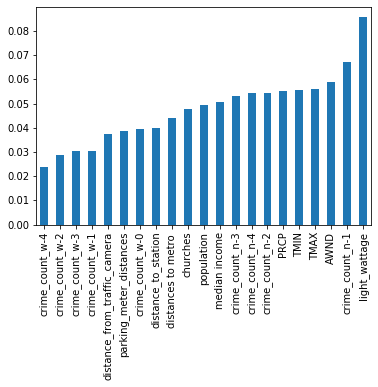

In [37]:
pd.Series(importances, index=x_cols).sort_values().plot.bar()

In [38]:
yproba = cross_val_predict(classifier, Xtrain,ytrain, method='predict_proba', cv =5)

In [ ]:
'''
now we see the precision and recall curve which tells us we can get more precise predictions at the cost of lowering the 
total crime found. this is useful as it can help us set a specific threshold that is most optimal for police allocation
'''

In [39]:
precision, recall,threshold = precision_recall_curve(ytrain, yproba[:,1])

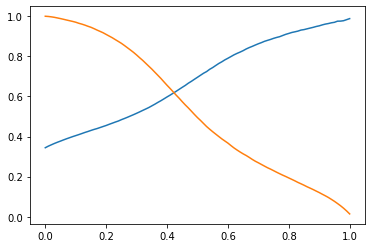

In [40]:
plt.plot(threshold,precision[:-1], label="precision")
plt.plot(threshold,recall[:-1], label='recall')

Text(0, 0.5, 'recall')

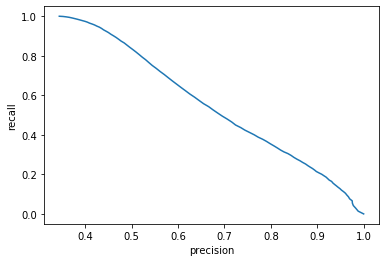

In [41]:
plt.plot(precision,recall)
plt.xlabel("precision")
plt.ylabel('recall')

In [42]:
from bokeh.io import output_notebook, show
output_notebook()
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource

Loading BokehJS ...

In [43]:
sources = ColumnDataSource(data =pd.DataFrame({'Threshold':threshold,'precision':precision[:-1],'recall':recall[:-1]}))

In [ ]:
'''
below here we can see that the model has precision and recall tradeoffs that we can actually use. using cost sensitive learning
it's actually possible to create the optimal threshold for police allocation or for other purposes.
by lowering recall (the amount of crimes captured by our model) we can make substatial precision gains (the amount of crimes
correctly identified). with higher precision, police will be sent to areas that have a higher probability of crime
thus potentially reducing the oppurtunity cost
'''

In [44]:
p = figure()
r1 = p.line(x='Threshold',y='precision', source = sources)
p.add_tools(HoverTool(renderers=[r1],mode ='vline', tooltips=[('(x, y)', '(@Threshold, @precision)')]))

r2 = p.line(x='Threshold',y='recall', source = sources, color='red')
p.add_tools(HoverTool(renderers=[r2],mode ='vline', tooltips=[('(x, y)', '(@Threshold, @recall)')]))

show(p)

In [45]:
a = figure()
r1 = a.line(x='recall',y='precision', source = sources)
a.add_tools(HoverTool(renderers=[r1],mode ='vline', tooltips=[('(recall, precision)', '(@recall, @precision)')]))

show(a)

In [46]:
'''
x_cols = ['light_wattage','population','church per pop','year','distances to metro ','distance_to_station','crime_count',
          'PRCP','TMIN','AWND']
          p= 66, r = 50
          
'''

"\nx_cols = ['light_wattage','population','church per pop','year','distances to metro ','distance_to_station','crime_count',\n          'PRCP','TMIN','AWND']\n          p= 66, r = 50\n          \n"

In [47]:
crime_final.columns

Index(['year', 'week', 'geohash', 'crime_count_w-0', 'population', 'holidays',
       'AWND', 'PRCP', 'TMAX', 'TMIN', 'RANGE', 'ave_temp', 'light_wattage',
       'distances to metro ', 'median income', 'churches', 'PSUN', 'TSUN',
       'distance_to_station', 'crime_count_w-1', 'crime_count_w-2',
       'crime_count_w-3', 'crime_count_w-4', 'crime_count_w-5', 'crime_count',
       'crime_count_n-1', 'crime_count_n-2', 'crime_count_n-3',
       'crime_count_n-4', 'parking_meter_distances',
       'distance_from_traffic_camera', 'target_crime_classificiation'],
      dtype='object')

In [48]:
crime_final[(crime_final['crime_count_n-2'] !=0)|(crime_final['crime_count_n-1'] !=0)|(crime_final['crime_count_w-1'] !=0)|(crime_final['crime_count_w-2'] !=0)&(crime_final['crime_count'] !=0)].shape

(112971, 32)